In [58]:
#Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [59]:
#Dataload
data = pd.read_csv('disney_plus_shows.csv')

In [60]:
#Structure review
print(data.head())
print(data.info())
print(data.columns)

     imdb_id                                       title  \
0  tt0147800                  10 Things I Hate About You   
1  tt7019028                        101 Dalmatian Street   
2  tt0115433                              101 Dalmatians   
3  tt0324941  101 Dalmatians 2: Patch's London Adventure   
4  tt0211181                              102 Dalmatians   

                                                plot    type  rated   year  \
0  A pretty, popular teenager can't go out on a d...   movie  PG-13   1999   
1  This series follows the lives of Delilah and D...  series    NaN  2018–   
2  An evil high-fashion designer plots to steal D...   movie      G   1996   
3  Being one of 101 takes its toll on Patch, who ...   movie      G   2002   
4  Cruella DeVil gets out of prison and goes afte...   movie      G   2000   

   released_at           added_at  runtime  \
0  31 Mar 1999  November 12, 2019   97 min   
1  25 Mar 2019  February 28, 2020      NaN   
2  27 Nov 1996  November 12, 201

In [37]:
# Delete duplicates
data = data.drop_duplicates()


In [ ]:
# Estandarización de formato

# Convert 'rated' to ordered numeric codes for correlation
# Clean text first
#data['rated'] = data['rated'].astype(str).str.upper().str.strip()
# Convert to ordered numeric codes
#order = ['G', 'PG', 'PG-13', 'R', 'NC-17']
#data['rated'] = pd.Categorical(data['rated'], categories=order, ordered=True).codes

data['year'] = pd.to_numeric(data['year'], errors='coerce').astype('Int64')
data['imdb_votes'] = data['imdb_votes'].replace(',', '', regex=True).astype(float)
data['metascore'] = 


In [39]:
#Missing values
print(data.isnull().sum())

imdb_id         24
title           24
plot            52
type            24
rated            0
year           203
released_at     44
added_at         0
runtime         80
genre           33
director       229
writer         175
actors          48
language        62
country         49
awards         362
metascore      626
imdb_rating     39
imdb_votes      39
dtype: int64


In [40]:
#Handling missing values

#Dependant variable IMDb rating (se elimina)
data = data.dropna(subset=['imdb_rating'])

#Release year (se elimina)
data = data.dropna(subset=['year'])

#Age rating (se usa la moda)
data['rated'].fillna(data['rated'].mode()[0], inplace=True)

#IMDb votes (se usa la mediana por sesgo)
data['imdb_votes'].fillna(data['imdb_votes'].median(), inplace=True)

/var/folders/1q/fbzt6nts1xl_y5fczn7gd0_00000gn/T/ipykernel_53211/1562610357.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['rated'].fillna(data['rated'].mode()[0], inplace=True)
/var/folders/1q/fbzt6nts1xl_y5fczn7gd0_00000gn/T/ipykernel_53211/1562610357.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

            rated         year   metascore  imdb_rating    imdb_votes
count  706.000000        706.0  292.000000   706.000000  7.060000e+02
mean    -0.111898  1994.116147   62.061644     6.587535  7.578183e+04
std      0.924190    24.147081   15.776455     1.004578  1.892003e+05
min     -1.000000       1928.0   19.000000     1.500000  5.000000e+00
25%     -1.000000       1986.0   51.000000     6.000000  9.162500e+02
50%      0.000000       2003.0   61.000000     6.700000  5.295000e+03
75%      1.000000       2011.0   73.000000     7.300000  3.870100e+04
max      2.000000       2020.0   99.000000     8.700000  1.225316e+06


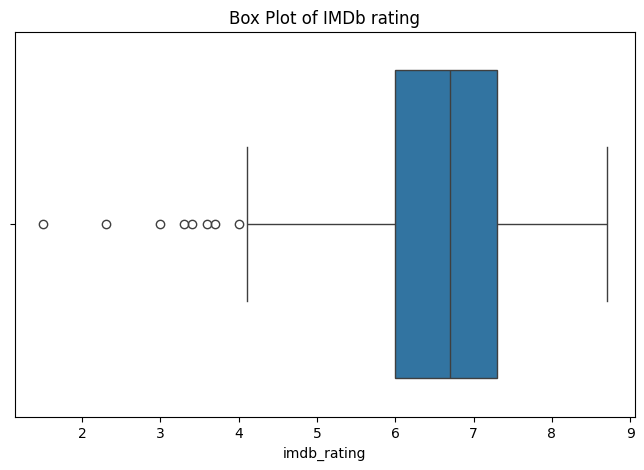

In [41]:
#Outliers 
print(data.describe())  

#boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['imdb_rating'])
plt.title("Box Plot of IMDb rating")
plt.xlabel("imdb_rating")
plt.show()

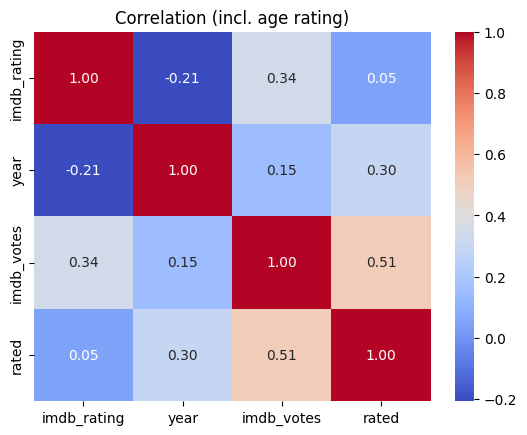

In [42]:
corr = data[['imdb_rating', 'year', 'imdb_votes', 'rated']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation (incl. age rating)')
plt.show()

In [43]:
data.info()
data.describe()
data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 706 entries, 0 to 991
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imdb_id      706 non-null    object 
 1   title        706 non-null    object 
 2   plot         689 non-null    object 
 3   type         706 non-null    object 
 4   rated        706 non-null    int8   
 5   year         706 non-null    Int64  
 6   released_at  703 non-null    object 
 7   added_at     706 non-null    object 
 8   runtime      686 non-null    object 
 9   genre        703 non-null    object 
 10  director     683 non-null    object 
 11  writer       636 non-null    object 
 12  actors       694 non-null    object 
 13  language     687 non-null    object 
 14  country      695 non-null    object 
 15  awards       437 non-null    object 
 16  metascore    292 non-null    float64
 17  imdb_rating  706 non-null    float64
 18  imdb_votes   706 non-null    float64
dtypes: Int64(1), 

imdb_id          0
title            0
plot            17
type             0
rated            0
year             0
released_at      3
added_at         0
runtime         20
genre            3
director        23
writer          70
actors          12
language        19
country         11
awards         269
metascore      414
imdb_rating      0
imdb_votes       0
dtype: int64

In [44]:
# Select the columns needed for regression
regression_data = data[['imdb_rating', 'year', 'rated', 'imdb_votes']]

# Check the new DataFrame
print(regression_data.head())
print(regression_data.info())


   imdb_rating  year  rated  imdb_votes
0          7.3  1999      2    283945.0
2          5.7  1996      0     97785.0
3          5.8  2002      0      7434.0
4          4.9  2000      0     33444.0
5          6.3  2011      1      4933.0
<class 'pandas.core.frame.DataFrame'>
Index: 706 entries, 0 to 991
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imdb_rating  706 non-null    float64
 1   year         706 non-null    Int64  
 2   rated        706 non-null    int8   
 3   imdb_votes   706 non-null    float64
dtypes: Int64(1), float64(2), int8(1)
memory usage: 23.4 KB
None


4.	Expected Modeling

In [ ]:
regression_data = data[['imdb_rating', 'year', 'rated', 'imdb_votes']]


X = regression_data[['year', 'rated', 'imdb_votes']]
y = regression_data['imdb_rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lm = LinearRegression()


lm.fit(X_train, y_train)


y_pred = lm.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Print model coefficients and intercept
print("Coefficients:", lm.coef_)
print("Intercept:", lm.intercept_)


Mean Squared Error (MSE): 0.8443887445028947
R-squared (R2): 0.2144285962835929
Coefficients: [-9.55772216e-03 -1.12358790e-01  2.25868259e-06]
Intercept: 25.475217611752758


In [46]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.9189062762343583


In [53]:
print("IMDb rating std:", data['imdb_rating'].std())


IMDb rating std: 1.0203516652049083


Step-wise model

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def fit_and_eval(X, y):
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    return r2_score(y, y_pred), np.sqrt(mean_squared_error(y, y_pred))

# Model 1: only IMDb votes
r2_1, rmse_1 = fit_and_eval(regression_data[['log_votes']], regression_data['imdb_rating'])
print("Model 1 (votes):", r2_1, rmse_1)

# Model 2: votes + year
r2_2, rmse_2 = fit_and_eval(regression_data[['log_votes','year']], regression_data['imdb_rating'])
print("Model 2 (votes + year):", r2_2, rmse_2)

# Model 3: votes + year + rated
r2_3, rmse_3 = fit_and_eval(regression_data[['log_votes','year','rated']], regression_data['imdb_rating'])
print("Model 3 (all):", r2_3, rmse_3)


Model 1 (votes): 0.012975025146112817 0.9973328215716959
Model 2 (votes + year): 0.06266442455849297 0.9719044954967404
Model 3 (all): 0.06356392180000259 0.9714380482232178


STEP WISE 

In [77]:
#Dataload
data = pd.read_csv('disney_plus_shows.csv')

In [78]:
import pandas as pd
import numpy as np

# --- Clean runtime ---
data['runtime'] = (
    data['runtime']
    .astype(str)
    .str.replace('min', '', regex=False)
    .str.strip()
)
data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')

# --- Clean metascore ---
data['metascore'] = pd.to_numeric(data['metascore'], errors='coerce')

# --- Clean imdb_votes ---
data['imdb_votes'] = (
    data['imdb_votes']
    .astype(str)
    .str.replace(',', '', regex=True)
    .astype(float)
)
data['log_votes'] = np.log1p(data['imdb_votes'])

# --- Binary encode for awards and type ---
data['has_awards'] = data['awards'].notna().astype(int)
data['is_series'] = (data['type'] == 'series').astype(int)

# --- Genre (first listed genre only) ---
data['main_genre'] = data['genre'].astype(str).str.split(',').str[0].str.strip()
data = pd.get_dummies(data, columns=['main_genre'], drop_first=True)

# --- Drop missing target ---
data = data.dropna(subset=['imdb_rating'])


In [79]:
# Variables predictoras
features = ['year', 'rated', 'runtime', 'metascore', 'log_votes', 'has_awards', 'is_series'] + \
           [col for col in data.columns if col.startswith('main_genre_')]

regression_data = data[features + ['imdb_rating']].dropna()


In [80]:
import numpy as np
import pandas as pd

# --- rated: ordinal numérico ---
data['rated'] = data['rated'].astype(str).str.upper().str.strip()
order = ['G','PG','PG-13','R','NC-17']
data['rated_ord'] = pd.Categorical(data['rated'], categories=order, ordered=True).codes
data.loc[data['rated_ord'] == -1, 'rated_ord'] = np.nan
data['rated_ord'] = data['rated_ord'].astype(float)

# --- imdb_votes: numérico + log ---
data['imdb_votes'] = (data['imdb_votes'].astype(str)
                      .str.replace(',', '', regex=True).str.strip())
data['imdb_votes'] = pd.to_numeric(data['imdb_votes'], errors='coerce')
data['log_votes'] = np.log1p(data['imdb_votes'])

# --- year ---
data['year'] = pd.to_numeric(data['year'], errors='coerce')

# --- runtime: "97 min" -> 97 ---
data['runtime'] = (data['runtime'].astype(str).str.replace('min','',regex=False)
                   .str.strip())
data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')

# --- metascore (si existe) ---
if 'metascore' in data.columns:
    data['metascore'] = pd.to_numeric(data['metascore'], errors='coerce')

# --- type: series/movie -> 0/1 ---
data['is_series'] = (data['type'].astype(str).str.lower().str.strip() == 'series').astype(int)

# --- awards (binario simple) ---
data['has_awards'] = data['awards'].notna().astype(int)

# --- main_genre: primer género y dummies ---
data['main_genre'] = data['genre'].astype(str).str.split(',').str[0].str.strip()
genre_dum = pd.get_dummies(data['main_genre'], prefix='genre', drop_first=True)

# --- armar dataframe solo con numéricos ---
base_feats = ['year','rated_ord','runtime','log_votes','metascore','is_series','has_awards']
base_feats = [f for f in base_feats if f in data.columns]  # por si falta alguno
regression_data = pd.concat([data[base_feats], genre_dum, data['imdb_rating']], axis=1)

# limpiar filas con NaN en target o en features
regression_data = regression_data.dropna(subset=['imdb_rating'])
regression_data = regression_data.dropna()  # todas las features numéricas


In [81]:
ordered = [c for c in ['metascore','log_votes','runtime','year','rated_ord','is_series','has_awards'] if c in regression_data.columns]
ordered += [c for c in regression_data.columns if c.startswith('genre_')]

regression_data = regression_data[ordered + ['imdb_rating']]
results = stepwise_evaluation(regression_data, 'imdb_rating')


In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

def stepwise_evaluation(df, target):
    predictors = [c for c in df.columns if c != target]
    results = []

    for i in range(1, len(predictors) + 1):
        subset = predictors[:i]
        X = df[subset]
        y = df[target]
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        results.append((subset, r2, rmse))
    
    return results

results = stepwise_evaluation(regression_data, 'imdb_rating')
for subset, r2, rmse in results:
    print(f"Vars: {subset} → R²={r2:.3f}, RMSE={rmse:.3f}")


Vars: ['metascore'] → R²=0.531, RMSE=0.738
Vars: ['metascore', 'log_votes'] → R²=0.587, RMSE=0.692
Vars: ['metascore', 'log_votes', 'runtime'] → R²=0.601, RMSE=0.680
Vars: ['metascore', 'log_votes', 'runtime', 'year'] → R²=0.602, RMSE=0.680
Vars: ['metascore', 'log_votes', 'runtime', 'year', 'rated_ord'] → R²=0.602, RMSE=0.680
Vars: ['metascore', 'log_votes', 'runtime', 'year', 'rated_ord', 'is_series'] → R²=0.602, RMSE=0.680
Vars: ['metascore', 'log_votes', 'runtime', 'year', 'rated_ord', 'is_series', 'has_awards'] → R²=0.607, RMSE=0.676
Vars: ['metascore', 'log_votes', 'runtime', 'year', 'rated_ord', 'is_series', 'has_awards', 'genre_Adventure'] → R²=0.610, RMSE=0.673
Vars: ['metascore', 'log_votes', 'runtime', 'year', 'rated_ord', 'is_series', 'has_awards', 'genre_Adventure', 'genre_Animation'] → R²=0.614, RMSE=0.669
Vars: ['metascore', 'log_votes', 'runtime', 'year', 'rated_ord', 'is_series', 'has_awards', 'genre_Adventure', 'genre_Animation', 'genre_Biography'] → R²=0.626, RMSE=0.